# Linux NLP - SUDO GET LANGUAGE COUNT

## PREDICTING PROGRAMMING LANGUAGE WITHIN LINUX README REPOS

by Andrew Rachuig, Stephen Fitzsimon and Jennifer Eyring

_______________________________

<b>Introduction Notes:</b> This NLP project is based on utilizing webscraping methods to create a predictive Logistical Regression Model.
<br>
<br>
Our team scraped the top 3,300 most-forked Linux Github repositories (as of July 20, 2022) to determine what are the top programming languages being used on Github projects.
<br>
<br>
After finding the top languages being used for each Github repo, we then took the words/wording within the README sections of the repos to see if we could build a model that could predict what programming language was used; solely based on the README content and text.
<br>
<br>
### <b>Audience Notes about the Data:</b> 
The source of our data came from webscraping the top-forked Linux Github repositiories, by searching Linux and then also pulling the content of Linux's three common flavors: Arch, Debian and Ubuntu. You can read more of the step-by-step of how to replicate this repo in the README section.


__________________

## Initial Questions when starting this project:

> - How many & what are the unique words to each specific programming language?<br><br>
> - Are there any bigrams/trigrams that are specific to certain programming languages?<br><br>
> - Are there differences in words/phrases to Linux-flavors- specifically Ubuntu, Debian and Archlinux.<br><br>
> - Do certain programming languages have larger README sections than others? And if so, which ones?<br><br>
> - With Linux-flavors-Debian, Arch and Ubuntu-are there differences in README lengths? (ie does one flavor over the others seem to have more details needed or explained than others?)

__________________________

# Project Goals:

> - Utilize Codeup's webscraping function and apply it to our project's parameters of obtaining the top-forked Linux repositories.<br><br>
> - To determine any commonalities/differences between programming languages and the README sections of the repositories.<br><br>
> - Create a classification model that can predict what programming language is used, solely based on the README content/words.

# Executive Summary:

___________________________________________

<h1>ABOUT THE DATA:</h1>

Our team collected 3,300 top-forked Github repos that were specific flavors of Linux: Archlinux, Ubuntu, and Debian repositiores. Each flavor we pulled 1,100 and then combined these webscraped repositories into one large dataframe.

### Key notes:
- 3,300 repositories were collected.
- 2,805 were used in this model, after clean/normalizing data.
- <b>Top 3 programming languages used in all the repos:
    - 1) Shell
    - 2) Python
    - 3) C


<div class="alert alert-info">
    
### Size of data:
<b>Pre-Clean/Normalize: 3,300 rows | 3 columns

<b>After cleaning & normalizing: 2,805 rows | 6 columns
</div>

## Wrangle Process:

#### Measures taken to clean and normalize the data:

> 1) We dropped all nulls as these related to repos that had no languages defined.<br><br>
> 2) Using NLTK tools, we replaced any abnormal symbols and https-related phrases with single spaces on the readme_contents column.<br><br>
> 3) We tokenized the dataset on this same column.<br><br>
> 4) After cleaning/normalizing, we had used the proportions of most common words throughout the repos across every programming language to determine which words need to be removed as they took away from the information the corpus was provided on predictability.<br><br>
> 5) We lowered all capitilizations within the readme content.<br><br>
> 6) And finally we stemmed all words so keep key words/phrases similar.<br><br>
> 7) We added the following columns:
- `disto` : to label which repos were Arch, Ubuntu or Debian
- `clean_readme` : to have a comparison of the original collected text `readme_contents`
- `length_readme`: counts how many unique words are in each repo.

______________________

## Exploring the main dataset:

#### Calling in the data:

In [1]:
#imports:

#tools for web scraping:
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np

#group imports
import env
import acquire
import constants_prepare as c

import json
from typing import Dict, List, Optional, Union, cast
import requests
import nltk

#visualizations:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#calling in master_df:
master_df = pd.read_csv('master_list.csv')

#handling nulls of rows that do not have languages mentioned:
master_df = c.drop_nulls(master_df)

#importing our clean/normalization function
master_df = c.adding_columns(master_df)
master_df.head()

,repo,language,readme_contents,distro,clean_readme,length_of_readme
0,dockerfile/ubuntu,Shell,## Ubuntu Dockerfile\n\n\nThis repository cont...,ubuntu,"[ubuntu, dockerfil, repositori, contain, docke...",31
1,boxcutter/ubuntu,Shell,# Packer templates for Ubuntu written in legac...,ubuntu,"[packer, templat, ubuntu, written, legaci, jso...",501
2,wszqkzqk/deepin-wine-ubuntu,C,# Deepin wine for Ubuntu and Debian\n\n## 一、项目...,ubuntu,"[deepin, wine, ubuntu, debian, deepinwin, ubun...",164
3,fcwu/docker-ubuntu-vnc-desktop,HTML,# docker-ubuntu-vnc-desktop\n\n[![Docker Pulls...,ubuntu,"[dockerubuntuvncdesktop, docker, pull, docker,...",386
4,docker-32bit/ubuntu,Shell,ubuntu\n======\n\nBuild a docker image for ubu...,ubuntu,"[ubuntu, build, docker, imag, ubuntu, i386, ru...",14


### Average length of Repositories:

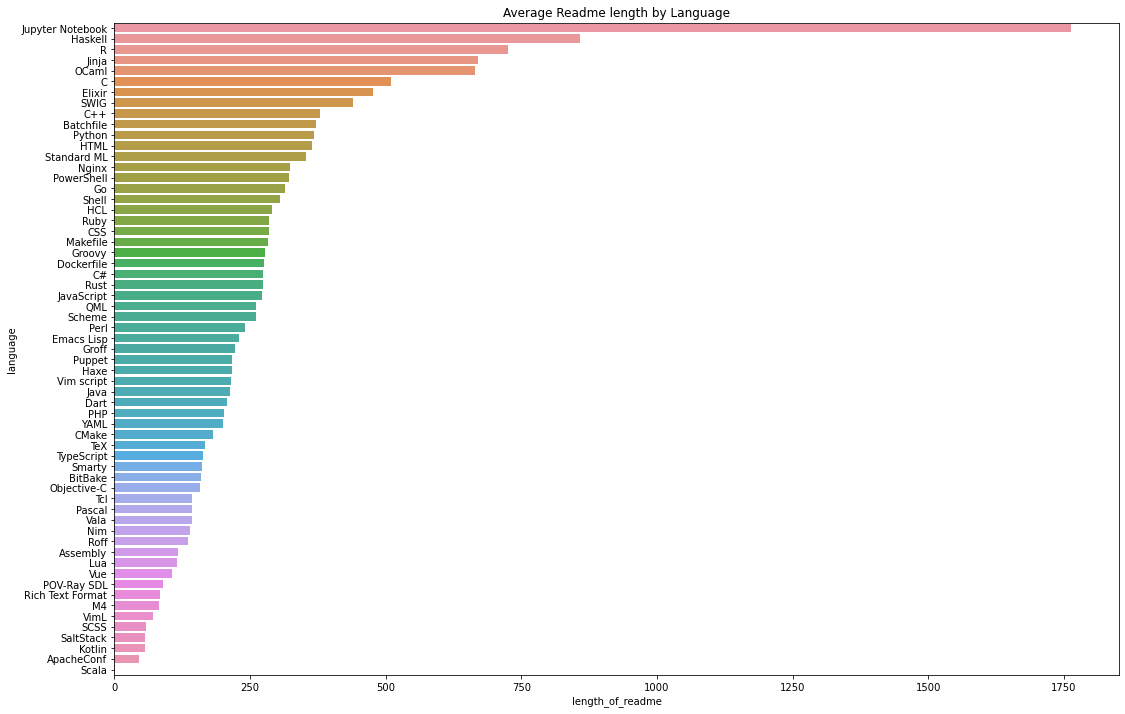

In [3]:
plt.figure(figsize=(18, 12))
sns.barplot(data = master_df.groupby('language').mean().reset_index().sort_values('length_of_readme', ascending=False), x = 'length_of_readme', y='language')
plt.title('Average Readme length by Language')
plt.show()

_____________________________________

### TOP 10 COMMON LANGUAGES USED IN FULL CORPUS:

In [4]:
master_language_count=pd.concat([master_df.language.value_counts(), master_df.language.value_counts(normalize=True)], axis = 1). head(10)
master_language_count

,language,language
Shell,1598,0.569697
Python,289,0.103030
C,141,0.050267
Dockerfile,99,0.035294
C++,63,0.022460
HTML,59,0.021034
JavaScript,53,0.018895
Makefile,52,0.018538
CSS,48,0.017112
Ruby,48,0.017112


In [5]:
m_count = master_df.language.value_counts(normalize=True).head(10)

In [6]:
#creating a df of the percentages to prep for charts:
temp = pd.DataFrame({'language' : m_count.index, 'percentage': m_count.values})

Text(0.5, 1.0, 'Percentages of the Top 10 Linux Repo languages')

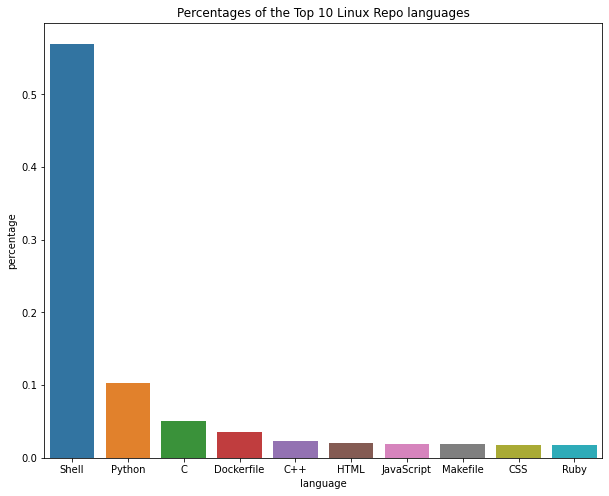

In [7]:
#plotting out the percentages of the Top 10 languages used in Ubuntu repos:
plt.figure(figsize=(10,8))
sns.barplot(data=temp, x = 'language', y = 'percentage')
plt.title('Percentages of the Top 10 Linux Repo languages')

### Top Words & Bigrams found in Shell:

In [8]:
shell_words = master_df[master_df.language == 'Shell'].clean_readme
shell_freq = pd.Series(shell_words.str.split()).value_counts()

In [9]:
shell_list = pd.Series((i[0] for i in shell_words))
shell_list.value_counts().nlargest(10)

arch        95
ubuntu      65
debian      50
applic      32
dotfil      27
instal      26
script      22
p           20
build       20
pkgbuild    18
dtype: int64

In [10]:
#taking a look at Shell words:
shell_list.describe()

count     1598
unique     861
top       arch
freq        95
dtype: object

#### Top Bigrams found in Shell:

In [11]:
#top bigrams of Shell language in Linux repos:
top_20_shell_bigrams = (pd.Series(nltk.ngrams(shell_list, 2))
                      .value_counts()
                      .head(20))

In [12]:
top_20_shell_bigrams

(arch, arch)              15
(dotfil, arch)            10
(debian, debian)           7
(applic, applic)           6
(ubuntu, ubuntu)           6
(arch, pkgbuild)           5
(script, applic)           4
(alignc, arch)             4
(p, ubuntu)                4
(arch, link)               4
(arch, applic)             4
(pkgbuild, dotfil)         3
(packer, ubuntu)           3
(ubuntu, packer)           3
(ubuntu, termuxubuntu)     3
(arch, linux)              3
(archbootstrap, luke)      2
(arch, vdr4arch)           2
(arch, archfi)             2
(archtitu, arch)           2
dtype: int64

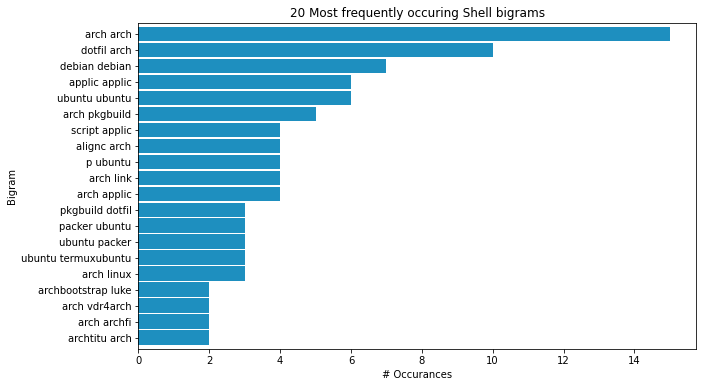

In [13]:
top_20_shell_bigrams.sort_values().plot.barh(color='#1E8FBF', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Shell bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_shell_bigrams.reset_index().sort_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


### Top Words & Bigrams found in Python:

In [14]:
python_words = master_df[master_df.language == 'Python'].clean_readme
python_freq = pd.Series(python_words.str.split()).value_counts()

In [15]:
#looking at where index starts?
python_words

15      [ubuntu, tweak, introduct, ubuntu, tweak, tool...
51      [consoleconf, ubuntu, server, instal, snappi, ...
70      [ubuntu, postinst, script, python, script, avo...
79      [openstack, ubuntu, 1210, ubuntu, 1210ubuntu, ...
81      [formerli, known, ucustom, advanc, live, cd, c...
                              ...                        
3203    [helper, script, creat, arch, linux, iso, supp...
3209    [pynej, multi, arch, python, frontend, focu, l...
3257    [simpl, declar, packag, manag, arch, linux, li...
3262    [need, equiti, otherwi, sellbuy, gener, reduce...
3293    [need, use, rapidli, expand, linux, world, man...
Name: clean_readme, Length: 289, dtype: object

In [16]:
python_list = pd.Series((i[14] for i in python_words))
python_list.value_counts().nlargest(10)

IndexError: list index out of range

### Top Words and Bigrams found in C:

In [17]:
#taking all 'C' lanugage repos from the clean_readme 
C_words = master_df[master_df.language == 'C'].clean_readme
#finding the frequency of C words/grams
C_freq = pd.Series(C_words.str.split()).value_counts()

In [19]:
#creating a series for just unique C_words
C_list = pd.Series((i[0] for i in C_words))
C_list.value_counts().nlargest(10)

linux      16
ubuntu      5
deepin      4
alpm        4
readm       3
build       3
noah        2
dpkg        2
obsolet     2
w3m         2
dtype: int64

In [20]:
#taking a look at C_words
C_list.describe()

count       141
unique      105
top       linux
freq         16
dtype: object

#### Looking at Top 20 Bigrams of C language in repos:

In [21]:
#top bigrams of C language in Linux repos:
top_20_c_bigrams = (pd.Series(nltk.ngrams(C_list, 2))
                      .value_counts()
                      .head(20))

In [22]:
top_20_c_bigrams

(deepin, noah)                     2
(run, linux)                       2
(16github, obsolet)                2
(w3m, linux)                       2
(linux, w3m)                       2
(linux, 16github)                  2
(noah, ubuntu)                     2
(deepin, run)                      2
(ubuntu, cve20213493)              2
(set, openblock)                   1
(thcbtcrngbruteforc, repo)         1
(mupdf, set)                       1
(internet, mupdf)                  1
(well, internet)                   1
(debian, well)                     1
(readm, debian)                    1
(opennhrp, readm)                  1
(repo, opennhrp)                   1
(file, zynqlinux)                  1
(zynqlinux, thcbtcrngbruteforc)    1
dtype: int64

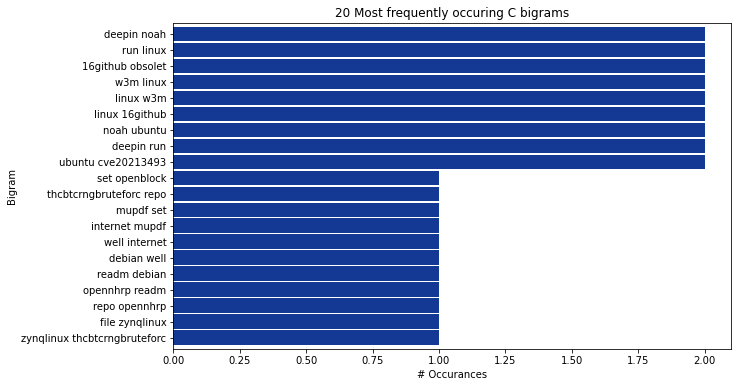

In [23]:
top_20_c_bigrams.sort_values().plot.barh(color='#143995', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring C bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_c_bigrams.reset_index().sort_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


### Overall Takeaways:

_______________________________________

## What words are not associated with a language?

In [37]:
master_df.clean_readme.describe()

count                                                  2805
unique                                                 2427
top       [openvpninst, test, visitor, say, thank, openv...
freq                                                      6
Name: clean_readme, dtype: object

In [43]:
#creating an 'other' list for languages to help find any words not associated with a language and the count of this:
keep_languages = master_df.language.value_counts().nlargest(10).index.tolist()
master_df.loc[~(master_df.language.isin(keep_languages)), 'language'] = 'other'

master_df.language.value_counts()

Shell         1598
other          403
Python         289
C              141
Dockerfile      99
C++             63
HTML            59
JavaScript      53
Makefile        52
Ruby            48
Name: language, dtype: int64

In [44]:
languages = master_df.language.unique().tolist()
languages = ['all'] + languages

In [45]:
print(languages)

['all', 'Shell', 'C', 'HTML', 'Ruby', 'C++', 'other', 'Python', 'Dockerfile', 'Makefile', 'JavaScript']


In [ ]:
#I don't think that the clean_data is working? (see below)

In [55]:
corpora = []
corpora.append({'language':'all', 'corpus':linux_corpus_list})
for lang in languages[1:]:
    corpora.append({'language':lang, 'corpus': ' '.join(master_df[master_df.language == lang].readme_contents.apply(c.clean_data))})

TypeError: sequence item 0: expected str instance, list found

In [47]:
#creating corpora of these languages:
df_corpora = pd.DataFrame(corpora)
df_corpora

,language,corpus
0,all,"[ubuntu, dockerfil, repositori, contain, docke..."
1,Shell,"[ubuntu, dockerfil, repositori, contain, docke..."
2,C,"[deepin, wine, ubuntu, debian, deepinwin, ubun..."
3,HTML,"[dockerubuntuvncdesktop, docker, pull, docker,..."
4,Ruby,"[deprec, cookbook, deprec, instead, use, apt_r..."
5,C++,"[lightweight, vm, manag, linux, window, maco, ..."
6,other,"[ubuntu, 1804, ci, stig, build, statu, ansibl,..."
7,Python,"[ubuntu, tweak, introduct, ubuntu, tweak, tool..."
8,Dockerfile,"[use, quick, start, run, follow, get, start, e..."
9,Makefile,"[circl, ci, dockerfil, build, ubuntu1604, base..."


In [48]:
#now putting these into a series to then turn into a dataframe:
corpora_series = []
for corpus in corpora:
    corpora_series.append(pd.Series(corpus['corpus']).value_counts())
    
word_counts = pd.concat(corpora_series, axis = 1)
word_counts = word_counts.set_axis(languages, axis =1).fillna(0).apply(lambda s: s.astype(int))

In [50]:
word_counts

,all,Shell,C,HTML,Ruby,C++,other,Python,Dockerfile,Makefile,JavaScript
instal,15559,9719,650,321,234,319,1856,1771,155,229,304
use,13566,6848,1243,296,183,301,1954,1733,576,204,228
file,8417,4137,716,292,109,234,1168,1211,185,155,210
run,7918,4516,414,252,115,176,914,802,450,124,155
packag,7234,3564,433,71,130,105,1039,1388,67,219,218
...,...,...,...,...,...,...,...,...,...,...,...
0u,1,1,0,0,0,0,0,0,0,0,0
ciscoipsecvpninst,0,1,0,0,0,0,0,0,0,0,0
devwithdockeronubuntu,0,1,0,0,0,0,0,0,0,0,0
pythonpacman,0,0,0,0,0,0,0,1,0,0,0


In [39]:
linux_corpus_list = c.clean_data(linux_corpus)
pd.Series(linux_corpus_list).value_counts().nlargest(20)

instal      15559
use         13566
file         8417
run          7918
packag       7234
sudo         6455
script       5839
build        5256
configur     5071
linux        5006
set          4957
system       4517
default      4484
imag         4393
ubuntu       4384
version      4148
make         4079
kernel       3730
option       3682
need         3676
dtype: int64

#next steps:

-Explore by flavors of:
    
-Hypothesis/questions:
    
-Results/takeaways

-modeling

-results/takeaways

